In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add the project root to Python path so we can import proteinttt
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import warnings
import pandas as pd
import numpy as np
import time
import esm
import biotite.structure.io as bsio
from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score
from proteinttt.utils.plots import plot_mean_scores_vs_step
import torch
import argparse
import os
from proteinttt.utils.plots import plot_mean_scores_vs_step
# from proteinttt.utils.plots import plot_mean_scores_vs_step
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 1000)

/scratch/project/open-35-8/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/lightning_lite/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [2]:
base_path = Path("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/")
SUMMARY_PATH = base_path / 'proteinttt_results.tsv'
MSA_PATH = Path("/scratch/project/open-35-8/antonb/bfvd/bfvd_msa")
SUBSET_PATH = base_path / 'proteinttt_msa_testset.tsv'

# Choosing data

In [5]:
exp = 'experement_4e-06_32_128_256.0_100_nograd_3494645'  
df1 = pd.read_csv("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/experements_msa/" + exp + "/results.tsv", sep='\t')
df1.pLDDT_after.mean()

71.74750533879906

In [ ]:
# df1.to_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/proteinttt_plddt_comparison_test.tsv', sep='\t', index=False)

In [ ]:
# df1.rename(columns={'pLDDT_after': 'pLDDT_ESMFold_TTT_MSA'}, inplace=True)

In [ ]:
df = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/proteinttt_results.tsv', sep="\t")
df

,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time,difference_plddt
0,A7IUX3,3,40.184184,BASE,MYKMSLLVLTQEFQEEDMPWFGTAFLHPHVPNRGPCPSFHLDNPKNLLWVCEWYTCIYLAWDQDNQYTLGMMHTEIRRIHLPSHDRCLGFPGDTSMCCQLGLS,103,28.709551,36.696726,0.28594,0.331706,0.33734,0.350680,36.788191,7.987175
1,A0A6M9TZY3,7,40.185052,BASE+LOGAN+12CY,MLLDKPDQHVITEFDAFMENDKIILNGIFNDTAKKALNLSLPLGFFSISNYIYFNLPLLEFPSFVNNYTFKDPLHKERIHYSFELSNVYNNLQTDYFNNVIRHPLPKTKPVITGIKVLPKITRSIEGPSSRINNSDKDFNHREVHLERKKPYDKKPNMRETDQQNMPPPPLPKMKKIKTTSAESAAAPSSSQPANINDIDAHLQKYHQLFTKLIQEKEFKKYQKFVDDFKVFVTPIYHVIQANTLKYKPLIETYNRYVLECFVRHWKIKTTDNLKSSLHAISNTEYDNFIASYHNFNEMYITLNDMSNIKEDPDYTIIKEFVHEIVRLIGINNNI,335,42.312089,58.246706,0.43240,0.533388,0.39168,0.544333,185.468657,15.934617
2,A0A192GNL3,47,40.185311,BASE,MLPQNSQVVHGVQDGPPVGPQPAQALLKVPVDVRRQAQAGPLAGVKPRPRLGVGAHHTPGVPVPLILGAVQHVHLLPGPRGQRLGHPLDVVHPLAQHQPLYVGPEEHPVGQGGVPLGVLGLGLDHRVPVHLARDLAKLGLYVYARAEYLHLVGPGADPVHRAVLPAEKGPQCSVVVVVPHGCSAQTQQVRGPHRQENPTRHGGRQLVGLIYNQEKHCGRVLGLNPPVSQRSRTRHIQVPGQGVGRRGAGCKDPRVRKEPSRRVPPLSRQHPPVCQDEGGQPQPPPQLQGHECLAEAGRALEHAIPLGGNVAPGLLQYPFLVRSRRDGAPLPGGAVSGRRFASQDPGTPGEGDVGLSPRRKGKQVCFPRAGHVSIYRVEP,379,26.668830,28.764074,0.12965,0.622505,0.21060,0.608376,228.917387,2.095244
3,A0A8A1UFW7,10,40.185707,BASE+LOGAN,MIYVYAEEERWLSNSDCIHVHRTVFFASGLYRIPYYTSSFVSVGSFSHSGYKTGFLFFWSFFAVCCILREYTLSKSCSCSIYILNIKKK,89,30.481073,33.632799,0.36591,0.614272,0.38138,0.575195,37.040655,3.151726
4,A0A1V0SAK4,5,40.186713,BASE+LOGAN+12CY,MLYNNKELVIETFGGSHRSGGRHRSGGRHRSGGSRGSYSHESGGRSSYGNHRRDHHNYRSGSSKFHNRNHRHYNYGPTRHNFNRHGDVYINNNDNNYIRYNDSYPYFVDYYGPRGSLNLNDYYNPPFVQYPYYPYPYGISPDIYPDVHPGMLPNILPDASSSENTFIQYNKFPIQQTSNPEEEIQSFTNLTDPIVYSNNDYTYLYYIFSAVMVLVIVLVFFCFK,224,35.730510,40.695059,0.19140,0.738145,0.23107,0.710163,87.982680,4.964549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317877,A0A2L1IWE9,63,93.670303,BASE+LOGAN,MDWLECLDAQLMRDAIRPNETYWAAYQYFDSAPWKPLNPREFLQFWGILSDEERLMVLLEIG,62,51.504337,71.163864,0.62190,0.728560,0.43014,0.483579,37.609659,19.659527
317878,A0A410T6P2,668,93.670729,BASE+LOGAN,MFILANDVVVNLENVSNVNLVPNRNRIVFNMNYSIQMKHYGHKSLISDYVYWDAKDSNEYTRNLIKLKENEHFQREFFAKPKNDGFINVNEISSIKFLEDSRRIIFNLSHQVTFRDKSKNESLTSEFVYVDIGSKEAYEDYKELLLIELGL,151,75.742139,77.880681,0.81951,0.853354,0.81844,0.855309,51.004086,2.138542
317879,A0A6N1NJT8,10701,93.670778,BASE,MSTTTPILATHNLSSSWSTGYQVSITVKNNTQNPTTGWTVTFQIPLNVKVSSSWNCVLSVSGQTITAKNTSSNAVIRAGASINFGVQFTKPSTAPSTISNLQAIGTFSSPTPSPDPNPTPTPSPNGKIIEGYWESWDSKVPVNTIVNMKANLIDISFGTFTQTGTNTFVVSGVEASASTIKQLVSAAHSLGKKVKLSIGGATYPISKFLTSDAAANGLAQAVAAYVKTYSLDGVDYDIEDRPAANLQIALIKYTRQILGPNYLISYTAMSPASTTSPWSTVIYGAHTYLNTVSIMAYNYGPGYTFQQDVQNLIAKGVPANKIVVGLMPGRDDVGVLTDLNHIRTACNYIKQHNLAGIMFWSLNRDYLNLTGLGSSAAINTAHSILG,386,88.593733,88.699067,0.71833,0.897720,0.72431,0.917477,0.694196,0.105334
317880,H6X4A3,16,93.671705,BASE+LOGAN+12CY,MNKAQELKLCIQQLCTLRCENLRAIYEGDVIEVQRCETAIEAKEFEVNRLIDELCGEKK,59,85.141642,86.288463,0.99083,0.992313,0.93045,0.956026,37.536124,1.146821


In [29]:
# df1 = df1.merge(df[['id', 'pLDDT_after']] , on='id', how='left')
# df1.drop(columns=['pLDDT_ESMFold_TTT'], inplace=True)
# df1.rename(columns={'pLDDT_after': 'pLDDT_ESMFold_TTT'}, inplace=True)

In [30]:
df.lddt_after.describe()

count    100.000000
mean       0.674109
std        0.204814
min        0.271548
25%        0.500863
50%        0.686340
75%        0.842984
max        1.000000
Name: lddt_after, dtype: float64

In [23]:
# df_r = df.query('pLDDT_AlphaFold > 90 and pLDDT_before < 70').sample(100)
# df2 = df1.query('pLDDT_before <50')
# df3 = df1.query('pLDDT_before >50')

# df_r = pd.concat([df2.sample(40), df3.sample(60)])
# df_r.to_csv(SUBSET_PATH, sep="\t", index=False)
# df_r

<Axes: >

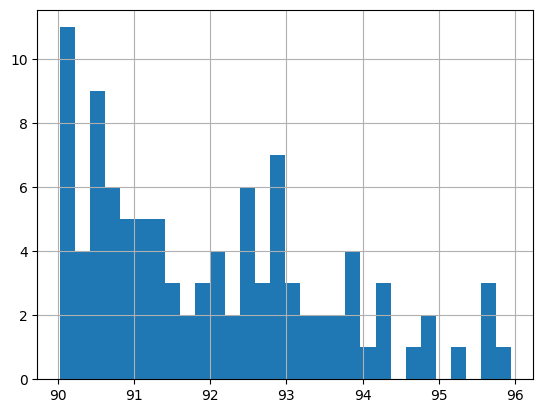

In [28]:
df_r.pLDDT_AlphaFold.hist(bins=30)

<Axes: >

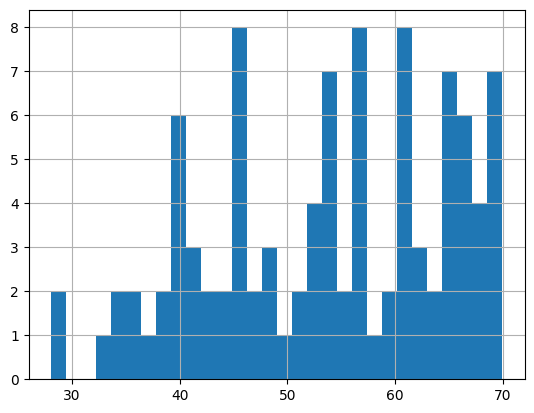

In [25]:
df_r.pLDDT_before.hist(bins=30)

<Axes: >

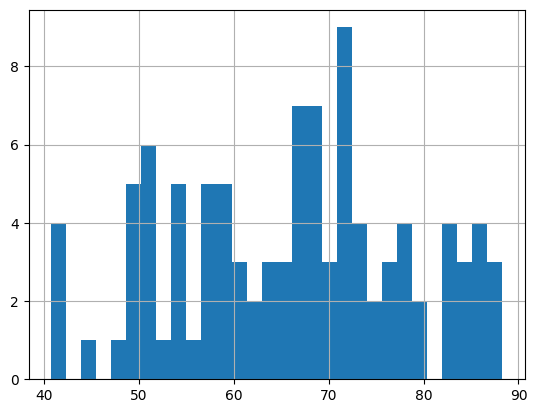

In [26]:
df_r.pLDDT_after.hist(bins=30)

<Axes: >

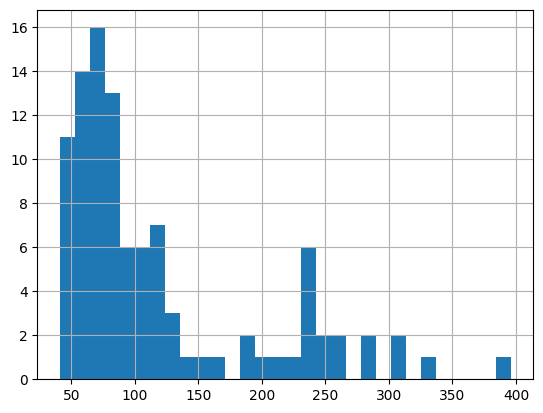

In [27]:
df_r.length.hist(bins=30)

In [9]:
# pd.read_csv(base_path / 'results_3314713.tsv', sep="\t")
# 4e-05 4
# 4e-04 4

# Merge results

In [ ]:
results = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/results_msa/results_3331216.tsv', sep="\t")[['id', 'nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt']]
for file in os.listdir(base_path/'results_msa'):
    if file.startswith("results_"):
        temp_df = pd.read_csv(base_path / 'results_msa' / file, sep="\t")
        results = pd.merge(results, temp_df.drop(columns=['nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt']), on='id', how='left')
results.head(10)

,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time,difference_plddt,pLDDT_0.006_32,lddt_0.006_32,tm_score_0.006_32,pLDDT_0.004_32_x,lddt_0.004_32_x,tm_score_0.004_32_x,pLDDT_0.04_32,lddt_0.04_32,tm_score_0.04_32,pLDDT_0.004_32_y,lddt_0.004_32_y,tm_score_0.004_32_y,pLDDT_0.004_32,lddt_0.004_32,tm_score_0.004_32
0,A0A6J5N0Y1,335,91.472759,BASE,MEYKKQLLNELEKLTSLMDIPFARRTDIHWILQNVVMNNTDEKKIKKVISICQLLVKDETNG,62,63.227515,82.740176,0.49006,0.559835,0.44111,0.505525,36.530101,19.512661,63.604403,0.548283,0.46251,63.268767,0.558804,0.48995,82.885303,0.952118,0.95047,63.406282,0.555533,0.48823,63.247613,0.559587,0.49035
1,A5A3S1,7,90.812526,BASE+LOGAN+12CY,MKEHVIIAPNYRLGEYAARFILEVSPRSCIFVSLDSRGDCERLNGLSDDLLNFHYFYAPRMDWTQEMRKNYEIMNHILAPRNIELTIHRLP,91,56.789921,77.589684,0.69936,0.683160,0.89881,0.854535,37.654090,20.799763,70.315474,0.822841,0.83486,82.878658,0.922131,0.94294,58.358539,0.485214,0.50258,78.929145,0.895523,0.91631,69.565776,0.781739,0.78265
2,A0A646QXE5,55,91.541814,BASE+LOGAN,MQVKITANANALVLGTDTLIAANNELYTKLETCHVEVNPSTGKIVKVHLDRPGNNHYDVLIGTTAGTVHRVQVGEITTSGGFCTYLDSL,89,39.286597,49.705892,0.28820,0.371947,0.43017,0.431789,35.734640,10.419295,39.958546,0.399711,0.35630,39.885277,0.396887,0.36370,69.930660,0.857406,0.86661,39.817826,0.382567,0.34833,39.333223,0.372618,0.28912
3,A0A7T0Q4S0,203,92.460221,BASE+LOGAN+12CY,MYFPVTIKIIQIEDKLDITIEKGIEAEFVITRAICSCGFMFKIPIIERSDTCFTYKSFYQTNYSGHHINNFKLSFVNGSAIVLSALEEFEGSQLELQHIFEFSLWDFTNFNSITHHYGYTCDYSQF,126,28.079356,53.452375,0.30882,0.303376,0.50438,0.395662,43.042365,25.373019,28.689577,0.301692,0.30486,29.123019,0.301743,0.30902,47.511452,0.602257,0.69404,28.626356,0.304184,0.29316,29.097490,0.301528,0.30598
4,A0A8S5SDJ0,147,92.442504,BASE,MKMFAEVRNDYCFEELKNGIKAGITIDVWKTDDENEEGEVAATVILSEHNDIIVVWHLNYARRDQECLLAIEEAKNILKEEI,82,67.063268,68.156072,0.80463,0.616864,0.81686,0.642290,35.410922,1.092804,67.111574,0.635749,0.80243,68.152774,0.633832,0.81425,75.699100,0.786859,0.88326,68.105262,0.637805,0.82194,67.663538,0.650042,0.81753
5,A0A516M7D4,316,90.798038,BASE,MKLIMENWKRFLKESEMYDYEPEKFGPLSVYHADAGEYGQIVLYHMMPKIGDNLIYLVGTLTYDLTMEPCVPETFQVSAVYVEKLARGNKYAKLMYDLAFYIVGEKGAGLTSDHMVGTTKIAKDKAWNYINSAESEYNKRKTDQGNAKFDYNNSTPDDPNDDCDSGLEGKEMATDYSYSMVNTSEPAAKYKMLIRNHLLNIRYLRGGKNMMWLEKELTNRADEGFNRAHLEQTSIED,237,46.566306,51.510262,0.50840,0.490958,0.63228,0.507660,97.545487,4.943956,47.318289,0.487412,0.54382,46.768948,0.488209,0.52815,76.871695,0.780295,0.84578,48.364375,0.487935,0.54321,46.851408,0.486633,0.52716
6,A0A516MKW5,12,92.879418,BASE+LOGAN+12CY,MTVGHSKELAKLIIELANNKKVNKEKLEKEIYNLALDVPNKFSLEIMNDFRSLKK,55,61.391902,73.575280,0.55549,0.806060,0.59163,0.845079,35.628690,12.183378,73.750313,0.758288,0.41334,74.098412,0.757720,0.41266,80.334989,0.783087,0.42788,76.301477,0.758511,0.40891,65.430559,0.803902,0.55206
7,A0A8S5MJ79,167,95.728745,BASE+LOGAN+12CY,MNMETKTYFLELVKQFGEFNNWKGYIDLYFTVKDMRKLKKLGVTKNNTIKEAYQILNK,58,62.752530,68.129717,0.67239,0.662824,0.76922,0.774342,35.602599,5.377186,86.227429,0.993497,0.98827,65.128178,0.622137,0.71628,86.394312,0.985891,0.98388,69.491215,0.749276,0.78334,63.455506,0.616540,0.74118
8,A0A6J7WBC6,66,92.714493,BASE,MTTLNKAQQRDIAKILVNGATLGDDYIARGLSALYRSALKTSQQDAILGLAIAYKVASNPEFIV,64,55.177619,82.571035,0.45614,0.580440,0.83349,0.798829,34.987408,27.393416,87.514203,0.972959,0.97621,78.831988,0.813052,0.84207,88.289420,0.978015,0.97822,86.891139,0.975043,0.97664,79.912422,0.809169,0.84247
9,A0A6J5NLC8,112,92.792529,BASE+LOGAN+12CY,MKIKEQSKDGIIYQLEMAFEEIGTALVDITYSGYTDASENSVLEFEWACASETDNTNLSEADIDRVNKILECGQEERIVRFLIDQYEKTDVRFDVGEYDWIIENM,105,61.165316,66.286546,0.67251,0.638203,0.82168,0.823579,35.856688,5.121230,65.604133,0.777225,0.83267,66.409344,0.809987,0.86027,83.646581,0.976580,0.97194,64.097869,0.768344,0.79487,61.231663,0.636910,0.67365


In [5]:
#drop columns with nan values
results = results.dropna(axis=1)

In [6]:
results.columns

Index(['id', 'nmsa', 'pLDDT_AlphaFold', 'version', 'sequence', 'length',
       'pLDDT_before', 'pLDDT_after', 'tm_score_before', 'lddt_before',
       'tm_score_after', 'lddt_after', 'time', 'difference_plddt',
       'pLDDT_0.006_32', 'lddt_0.006_32', 'tm_score_0.006_32',
       'pLDDT_0.004_32_x', 'lddt_0.004_32_x', 'tm_score_0.004_32_x',
       'pLDDT_0.04_32', 'lddt_0.04_32', 'tm_score_0.04_32', 'pLDDT_0.004_32_y',
       'lddt_0.004_32_y', 'tm_score_0.004_32_y', 'pLDDT_0.004_32',
       'lddt_0.004_32', 'tm_score_0.004_32'],
      dtype='object')

In [16]:
results = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/results_msa/results_3331218.tsv', sep="\t")

In [17]:
results['pLDDT_0.004_32'].mean()

59.72066081160506

In [7]:
# mean of the columns
results[['pLDDT_0.006_32', 'lddt_0.006_32', 'tm_score_0.006_32',
       'pLDDT_0.004_32_x', 'lddt_0.004_32_x', 'tm_score_0.004_32_x',
       'pLDDT_0.04_32', 'lddt_0.04_32', 'tm_score_0.04_32', 'pLDDT_0.004_32_y',
       'lddt_0.004_32_y', 'tm_score_0.004_32_y', 'pLDDT_0.004_32',
       'lddt_0.004_32', 'tm_score_0.004_32']].mean()


pLDDT_0.006_32         65.795193
lddt_0.006_32           0.735718
tm_score_0.006_32       0.684779
pLDDT_0.004_32_x       59.720661
lddt_0.004_32_x         0.671156
tm_score_0.004_32_x     0.609650
pLDDT_0.04_32          75.052996
lddt_0.04_32            0.833820
tm_score_0.04_32        0.788446
pLDDT_0.004_32_y       62.985478
lddt_0.004_32_y         0.708633
tm_score_0.004_32_y     0.650912
pLDDT_0.004_32         56.074821
lddt_0.004_32           0.630978
tm_score_0.004_32       0.572167
dtype: float64

# Plots

0.0005 64 1.0 8 32.0
0.008 32 1.0 64 128.0
pLDDT: 68.22571046527673, lddt: 0.7659873303839614, tm_score: 0.7114635999999999
0.001 64 1.0 8 32.0
0.04 32 1.0 16 32.0
0.04 32 1.0 32 128.0
0.04 32 1.0 16 16.0
0.04 32 1.0 8 32.0
0.001 64 1.0 64 128.0
pLDDT: 58.89597450961692, lddt: 0.662571991612331, tm_score: 0.6034217000000001
0.006 32 1.0 64 128.0
pLDDT: 67.31899203530243, lddt: 0.7520510383383298, tm_score: 0.7006051000000001
0.001 32 1.0 64 128.0
pLDDT: 58.68452977805739, lddt: 0.6567747496053034, tm_score: 0.5919471000000001
0.04 32 1.0 64 64.0
0.01 64 1.0 64 128.0
pLDDT: 70.63783470907167, lddt: 0.78696024961744, tm_score: 0.7324986999999997
0.008 64 1.0 64 128.0
pLDDT: 68.9646607607423, lddt: 0.781262785059303, tm_score: 0.7296441
0.004 32 1.0 128 256.0
0.04 32 1.0 8 16.0
0.006 64 1.0 64 128.0
pLDDT: 67.43412331082035, lddt: 0.755861213134423, tm_score: 0.7024841000000001
0.04 64 1.0 64 128.0
pLDDT: 76.28060029598788, lddt: 0.8527029300928222, tm_score: 0.8028261000000002
0.04 32 1.

/tmp/ipykernel_3486372/1245733313.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.index = pd.to_numeric(pivot_table.index, errors='ignore')
/tmp/ipykernel_3486372/1245733313.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.columns = pd.to_numeric(pivot_table.columns, errors='ignore')


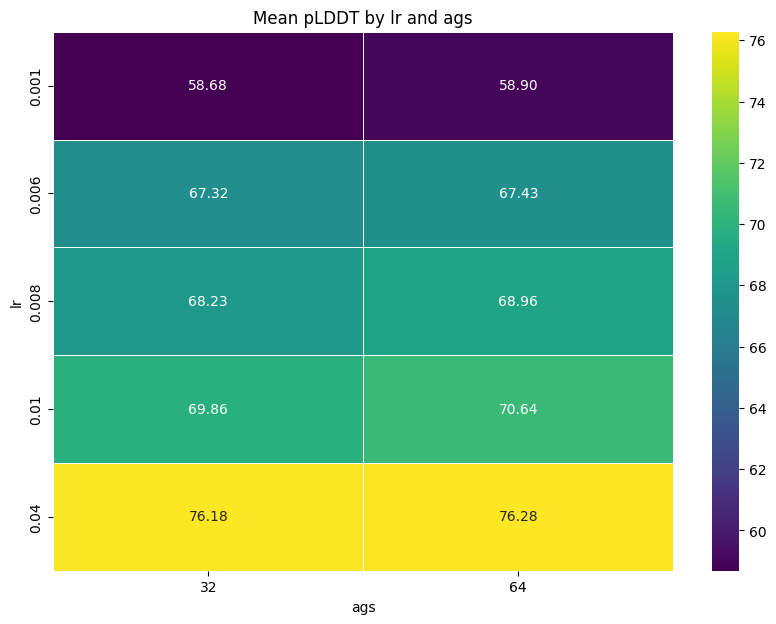

/tmp/ipykernel_3486372/1245733313.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.index = pd.to_numeric(pivot_table.index, errors='ignore')
/tmp/ipykernel_3486372/1245733313.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.columns = pd.to_numeric(pivot_table.columns, errors='ignore')


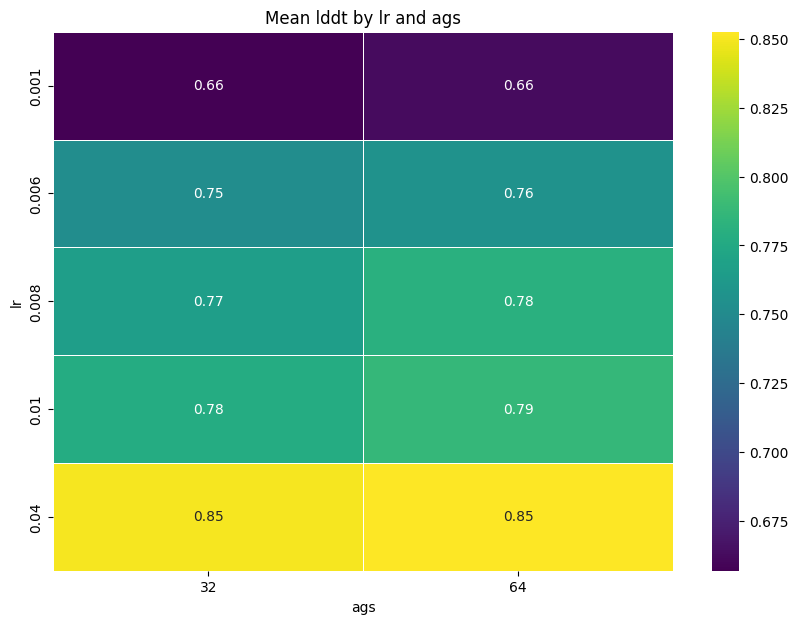

/tmp/ipykernel_3486372/1245733313.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.index = pd.to_numeric(pivot_table.index, errors='ignore')
/tmp/ipykernel_3486372/1245733313.py:65: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pivot_table.columns = pd.to_numeric(pivot_table.columns, errors='ignore')


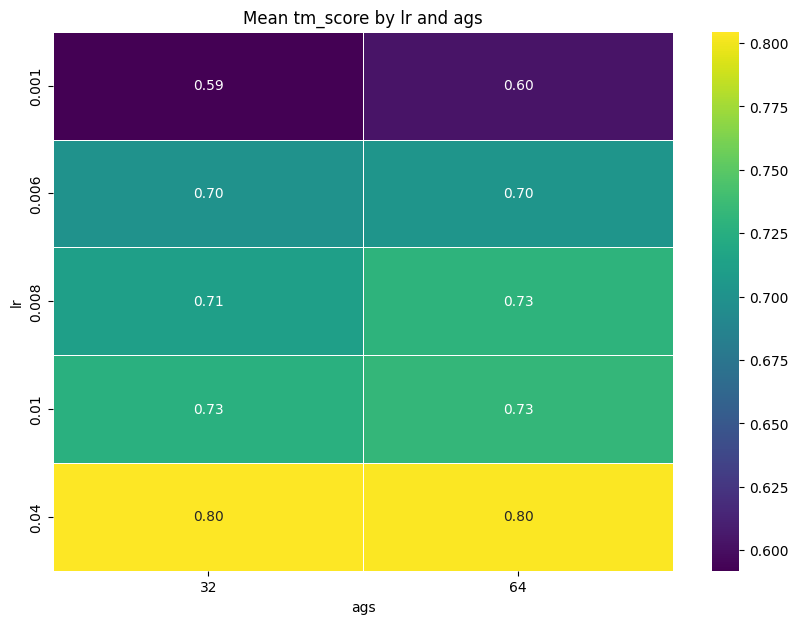

In [ ]:
base_path = Path("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/experements_msa")
# mean_metric_single = plot_mean_scores_vs_step('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/logs_msa/logs_msa_0.04_32', metric='plddt', choose_best_plddt=False)

data_for_heatmap = []

for experements in os.listdir(base_path):
    # for l in os.listdir(base_path / experements):
    if (base_path / experements / 'results.tsv').exists():
        try:
            lr = experements.split('_')[1]
            ags = experements.split('_')[2]
            grad_clip_max_norm = experements.split('_')[3]
            lora_rank = experements.split('_')[4]
            lora_alpha = experements.split('_')[5]
            JOB_SUFFIX = experements.split('_')[6]
        except:
            # lr = experements.split('_')[1]
            # ags = experements.split('_')[2]
            # grad_clip_max_norm = experements.split('_')[3]
            # lora_rank = '8'
            # lora_alpha = '32'
            # JOB_SUFFIX = None
            continue

        print(lr, ags, grad_clip_max_norm, lora_rank, lora_alpha)
        if lora_rank != '64' or lora_alpha != '128.0':
            continue
        
        results = pd.read_csv(base_path / experements / 'results.tsv', sep="\t")

        try:
            mean_plddt, mean_lddt, mean_tm_score = results[['pLDDT_after', 'lddt_after', 'tm_score_after']].mean()
            # mean_plddt, mean_lddt, mean_tm_score = results[['pLDDT_'+lr+'_'+ags, 'lddt_'+lr+'_'+ags, 'tm_score_'+lr+'_'+ags]].mean()  
        except:
            continue
        print(f"pLDDT: {mean_plddt}, lddt: {mean_lddt}, tm_score: {mean_tm_score}") 
        data_for_heatmap.append({'lr': lr, 'ags': ags, 'lora_rank': lora_rank, 'lora_alpha': lora_alpha, 'Metric': 'pLDDT', 'Mean Value': mean_plddt})
        data_for_heatmap.append({'lr': lr, 'ags': ags, 'lora_rank': lora_rank, 'lora_alpha': lora_alpha, 'Metric': 'lddt', 'Mean Value': mean_lddt})
        data_for_heatmap.append({'lr': lr, 'ags': ags, 'lora_rank': lora_rank, 'lora_alpha': lora_alpha, 'Metric': 'tm_score', 'Mean Value': mean_tm_score})

        # plot_mean_scores_vs_step(base_path / experements / 'logs' , metric='plddt', choose_best_plddt=False)
        # plot_mean_scores_vs_step(base_path / experements / 'logs' , metric='lddt', choose_best_plddt=False)
        # plot_mean_scores_vs_step(base_path / experements / 'logs' , metric='tm_score', choose_best_plddt=False)

heatmap_df = pd.DataFrame(data_for_heatmap)

if heatmap_df.empty or 'Metric' not in heatmap_df.columns:
    print("No data collected for heatmap. Nothing to plot. Check filters (lr=='0.004' and ags=='32') and results.tsv contents.")
else:
    metrics = heatmap_df['Metric'].unique()
    hparam_to_plot = ['lr', 'ags']
    for metric in metrics:
        metric_df = heatmap_df[heatmap_df['Metric'] == metric]
        pivot_table = metric_df.pivot_table(index=hparam_to_plot[0], columns=hparam_to_plot[1], values='Mean Value')

        # Sort the index: 8, 16, 32 etc 
        pivot_table.index = pd.to_numeric(pivot_table.index, errors='ignore')
        pivot_table.columns = pd.to_numeric(pivot_table.columns, errors='ignore')
        pivot_table = pivot_table.sort_index(ascending=True)
        pivot_table = pivot_table.sort_index(axis=1, ascending=True)

        plt.figure(figsize=(10, 7))
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
        plt.title(f'Mean {metric} by {hparam_to_plot[0]} and {hparam_to_plot[1]}')
        plt.xlabel(hparam_to_plot[1])
        plt.ylabel(hparam_to_plot[0])
        plt.show()

    

In [15]:
pivot_table

lora_alpha,128.0,16.0,32.0,64.0
lora_rank,,,,
8,NaN,0.755056,0.776498,NaN
64,0.804446,NaN,NaN,0.759066
32,0.617387,NaN,0.751806,0.777994
16,NaN,0.727185,0.779759,NaN


2


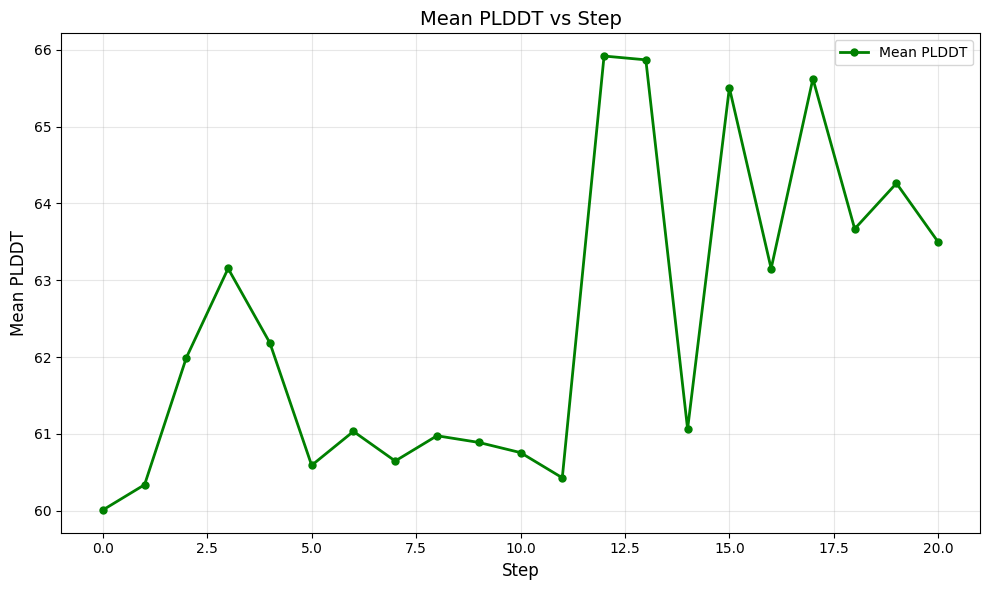

step
0     60.008841
1     60.338156
2     61.991896
3     63.153376
4     62.184259
5     60.590599
6     61.032312
7     60.646761
8     60.975685
9     60.889008
10    60.756239
11    60.428436
12    65.919100
13    65.869535
14    61.063324
15    65.506357
16    63.151962
17    65.623892
18    63.669250
19    64.262325
20    63.497101
Name: plddt, dtype: float64

In [8]:
# /scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/experements_msa/experement_0.04_32_1.0_64_128.0_momentum_3349812
# /scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/experements_msa/experement_0.04_64_1.0_8_16.0_100_steps_3349816

path = Path('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/experements_msa/experement_0.0005_64_1.0_8_32.0_3340967')
plot_mean_scores_vs_step(path  / 'logs' , metric='plddt', choose_best_plddt=False)
# print(pd.read_csv(path / 'results.tsv', sep="\t").pLDDT_after.mean())

In [ ]:

# plot_mean_scores_vs_step(LOGS_DIR, output_path=PLOT_PATH / f"plddt_vs_step_no_best_plddt.png", metric='plddt', choose_best_plddt=False)
# plot_mean_scores_vs_step(LOGS_DIR, output_path=PLOT_PATH / f"lddt_vs_step_no_best_plddt.png", metric='lddt', choose_best_plddt=False)
# plot_mean_scores_vs_step(LOGS_DIR, output_path=PLOT_PATH / f"tm_score_vs_step_no_best_plddt.png", metric='tm_score', choose_best_plddt=False)

# hyperparams = {
#     'lr': [0.004, 0.0004, 4e-05],
#     'ags': [4, 8, 16, 32]
# }
# for lr in hyperparams['lr']:
#     for ags in hyperparams['ags']:
#         print("LR:", lr)
#         print("AGS:", ags)
#         if lr == 0.004 and ags == 16:
#             plot_mean_scores_vs_step(base_path / f'logs_msa_{lr}_{ags}', metric='plddt')

In [3]:
from Bio import SeqIO


def check_a3m_lengths(filepath):
    lengths = {}
    try:
        for record in SeqIO.parse(filepath, format="fasta"):
            # DELETE all lowercase letters from the sequence
            for char in record.seq:
                if char.islower():
                    record.seq = record.seq.replace(char, "")
            lengths[record.id] = len(record.seq)

        first_record_id = list(lengths.keys())[0]
        reference_length = lengths[first_record_id]

        print(f"Reference sequence: '{first_record_id}' (Length: {reference_length})")

        is_consistent = True
        for seq_id, length in lengths.items():
            if length != reference_length:
                print(f"MISMATCH: '{seq_id}' has length {length}")
                is_consistent = False

        if is_consistent:
            print(f"All {len(lengths)} sequences have the same length: {reference_length}")

    except Exception as e:
        print(f"An error occurred: {e}")

file_to_check = "/scratch/project/open-35-8/antonb/bfvd/bfvd_msa/A0A1M7XUY2.a3m"
check_a3m_lengths(file_to_check)

Reference sequence: 'UniRef100_A0A1M7XUY2' (Length: 437)
All 2527 sequences have the same length: 437


In [30]:
results.pLDDT_after.mean(), results.pLDDT_before.mean(), results['pLDDT_0.0004_4'].mean()

(66.00136074541415, 53.70356051607253, 55.61832557561105)

In [23]:
t = pd.read_csv('/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/results_msa/results_3321816.tsv', sep="\t")
t['pLDDT_4e-05_8'].describe()
# t

count    100.000000
mean      61.406598
std       14.733958
min       29.159106
25%       47.411812
50%       63.373106
75%       71.816669
max       87.446723
Name: pLDDT_4e-05_8, dtype: float64

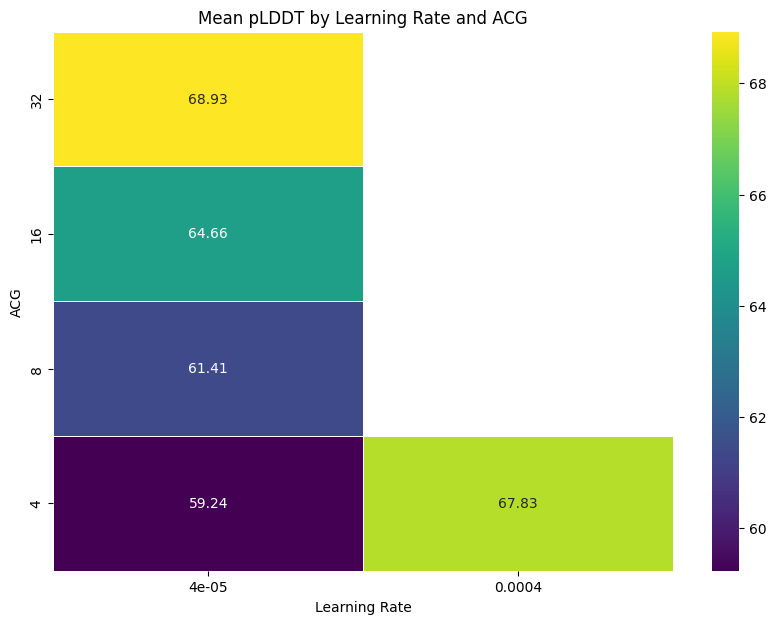

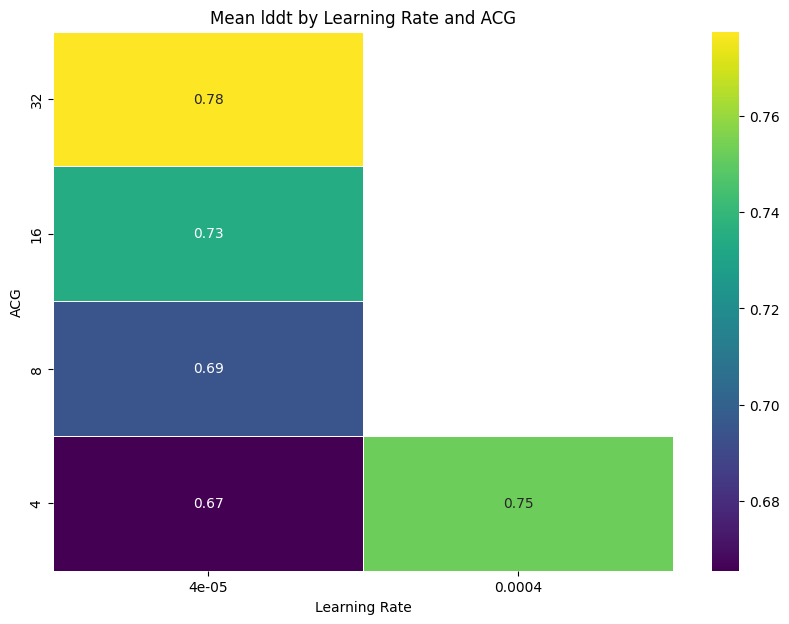

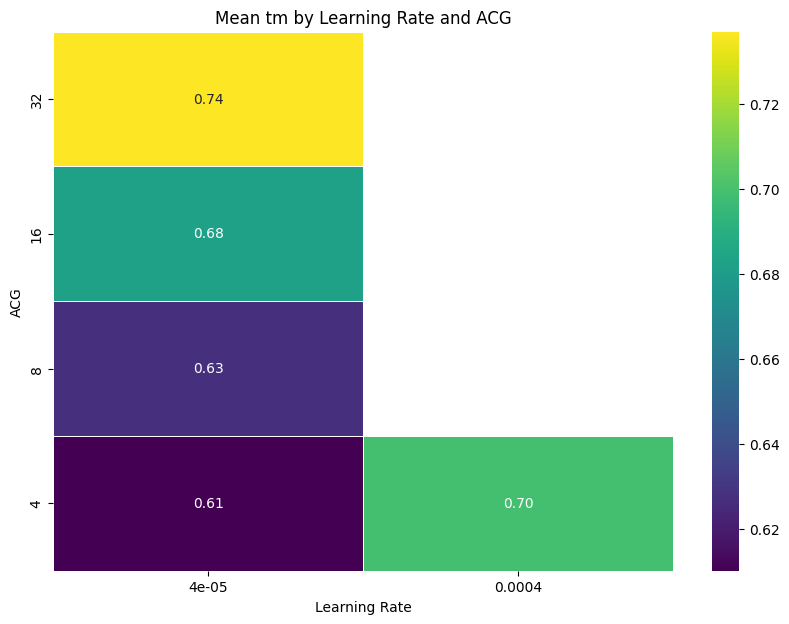

In [13]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Extract learning rate and acg from column names
# The column names are in the format "metric_learningrate_acg"
def extract_params(col_name):
    match = re.search(r'_(\d(?:\.\d+)?e?-?\d*)_(\d+)', col_name)
    if match:
        lr = float(match.group(1))
        acg = int(match.group(2))
        return lr, acg
    return None, None

# List of columns to process
columns_to_process = [
    'pLDDT_4e-05_4', 'lddt_4e-05_4', 'tm_score_4e-05_4', 'pLDDT_4e-05_16',
       'lddt_4e-05_16', 'tm_score_4e-05_16', 'pLDDT_4e-05_32', 'lddt_4e-05_32',
       'tm_score_4e-05_32', 'pLDDT_4e-05_8', 'lddt_4e-05_8',
       'tm_score_4e-05_8', 'pLDDT_0.0004_4', 'lddt_0.0004_4',
       'tm_score_0.0004_4'
]

# Create a list to store the extracted data
data_for_heatmap = []

for col in columns_to_process:
    lr, acg = extract_params(col)
    if lr is not None and acg is not None:
        # Assuming 'results' is your dataframe loaded in cell 11
        mean_value = results[col].mean()
        metric_name = col.split('_')[0] # e.g., pLDDT, lddt, tm_score
        data_for_heatmap.append({'Learning Rate': lr, 'ACG': acg, 'Metric': metric_name, 'Mean Value': mean_value})

# Convert to DataFrame for easier pivoting
heatmap_df = pd.DataFrame(data_for_heatmap)

# Pivot the table to get 'Learning Rate' on x-axis, 'ACG' on y-axis, and 'Mean Value' as values
# We will create a separate heatmap for each metric (pLDDT, lddt, tm_score)

metrics = heatmap_df['Metric'].unique()

for metric in metrics:
    metric_df = heatmap_df[heatmap_df['Metric'] == metric]
    pivot_table = metric_df.pivot_table(index='ACG', columns='Learning Rate', values='Mean Value')

    # Sort the index (ACG) and columns (Learning Rate) for better visualization
    pivot_table = pivot_table.sort_index(ascending=False)
    pivot_table = pivot_table.sort_index(axis=1)

    plt.figure(figsize=(10, 7))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
    plt.title(f'Mean {metric} by Learning Rate and ACG')
    plt.xlabel('Learning Rate')
    plt.ylabel('ACG')
    plt.show()
